In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tqdm.auto import tqdm

from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [2]:
df = pd.read_csv("../data/train.csv")
df.shape

(60487, 4)

In [3]:
def mirror_ts(data, n_points=25, x_col='x'):
    mirrored_df = []
    border = [0 for _ in range(n_points)]
    for _id, group in data.groupby('id'):
        x_list = group[x_col].to_list()
        x = x_list[:n_points][::-1]
        x += x_list
        x += x_list[::-1][:n_points]
        tmp = pd.DataFrame(x, columns=[x_col])
        tmp['id'] = _id
        tmp['y'] = border + group['y'].to_list() + border
        tmp['original'] = border + [1 for _ in range(group.shape[0])] + border
        mirrored_df.append(tmp)
    mirrored_df = pd.concat(mirrored_df).reset_index(drop=True)[['id', x_col, 'y', 'original']]
    return mirrored_df

In [4]:
def ts_features(dataframe, param, x_col='x', mirror_param=25):
    
    data = mirror_ts(dataframe, n_points=mirror_param, x_col=x_col)
    
    groups = data.groupby('id')
    for i in range(-param, param + 1):
        if i == 0:
            continue
        data[f'{x_col}_shift_{i}'] = groups[x_col].shift(i)
        data[f'{x_col}_delta_{i}'] = groups[x_col].diff(i)
        
    for i in range(-3, 4):
        for j in range(-3, 4):
            if i == 0 or j == 0 or i == j:
                continue
            values = (data[f'{x_col}_delta_{i}'] / (data[f'{x_col}_delta_{j}'] + 1e-9)).values
            data[f'{x_col}_delta_{i}_divide_delta_{j}'] = values
            
            values = (data[f'{x_col}_delta_{i}'] - data[f'{x_col}_delta_{j}']).values
            data[f'{x_col}_delta_{i}_substract_delta_{j}'] = values
            
            values = (data[f'{x_col}_shift_{i}'] / (data[f'{x_col}_shift_{j}'] + 1e-9)).values
            data[f'{x_col}_delta_{i}_divide_shift_{j}'] = values
            
            values = (data[f'{x_col}_shift_{i}'] - data[f'{x_col}_shift_{j}']).values
            data[f'{x_col}_shift_{i}_substract_shift_{j}'] = values
        
    data[f'{x_col}_dist_to_lower'] = data[x_col] - 400
    data[f'{x_col}_dist_to_upper'] = 1200 - data[x_col]
    
    for i in range(-3, 4):
        if i == 0:
            continue
        data[f'{x_col}_substract_shift_{i}'] = data[x_col] - data[f'{x_col}_shift_{i}']
        data[f'{x_col}_divide_shift_{i}'] = data[x_col] / (data[f'{x_col}_shift_{i}'] + 1e-9)
        data[f'{x_col}_substract_delta_{i}'] = data[x_col] - data[f'{x_col}_delta_{i}']
        data[f'{x_col}_divide_delta_{i}'] = data[x_col] / (data[f'{x_col}_delta_{i}'] + 1e-9)
    
    drop_columns = ['id', x_col, 'y', 'original']
    return data.loc[data['original'] == 1].drop(columns=drop_columns).reset_index(drop=True)


def window_features(dataframe, param=10, x_col='x', mirror_param=25):
    
    data = mirror_ts(dataframe, n_points=mirror_param, x_col=x_col)
    created_columns = []
    groups = data.groupby('id')[x_col]
    for i in range(2, param + 1):
        data[f'{x_col}_mean_{i}'] = groups.rolling(window=i).mean().values
        data[f'{x_col}_median_{i}'] = groups.rolling(window=i).median().values
        data[f'{x_col}_std_{i}'] = groups.rolling(window=i).std().values
        data[f'{x_col}_min_{i}'] = groups.rolling(window=i).min().values
        data[f'{x_col}_max_{i}'] = groups.rolling(window=i).max().values
        data[f'{x_col}_r_{i}'] = data[f'{x_col}_max_{i}'] - data[f'{x_col}_min_{i}']
        data[f'{x_col}_z_score_v1'] = (data[x_col] - data[f'{x_col}_mean_{i}']) / data[f'{x_col}_std_{i}']
        data[f'{x_col}_z_score_v2'] = (data[x_col] - data[f'{x_col}_median_{i}']) / data[f'{x_col}_std_{i}']
        data[f'{x_col}_z_score_v3'] = (data[x_col] - data[f'{x_col}_mean_{i}']) / data[f'{x_col}_r_{i}']
        data[f'{x_col}_z_score_v4'] = (data[x_col] - data[f'{x_col}_median_{i}']) / data[f'{x_col}_r_{i}']
        
        created_columns.extend(
            [
                f'{x_col}_mean_{i}', f'{x_col}_median_{i}', 
                f'{x_col}_std_{i}', f'{x_col}_min_{i}', 
                f'{x_col}_max_{i}', f'{x_col}_r_{i}',
                f'{x_col}_z_score_v1', f'{x_col}_z_score_v2', 
                f'{x_col}_z_score_v3', f'{x_col}_z_score_v4'
            ]
        )
    for col in created_columns:
        groups = data.groupby('id')[col]
        for i in [-2, -1, 1, 2]:
            data[f'{col}_shift_{i}'] = groups.shift(i).values
    drop_columns = ['id', x_col, 'y', 'original']
    return data.loc[data['original'] == 1].drop(columns=drop_columns).reset_index(drop=True)

In [5]:
def smooth_ts(dataframe, mirror_param=25):
    data = mirror_ts(dataframe)
    df_smooth = []
    for _id, group in data.groupby('id'):
        smoothed = group['x'].rolling(21).median().fillna(method='bfill').shift(-10).fillna(method='ffill')
        mask = group['x'] / smoothed
        group['mask'] = mask.values
        group['smooth'] = smoothed.values
        group.loc[group['mask'] > 1.75, 'x'] = group.loc[group['mask'] > 1.75, 'smooth']
        group = group.drop(columns = ['mask','smooth'])
        df_smooth.append(group)
    df_smooth = pd.concat(df_smooth, ignore_index=True).reset_index(drop=True).rename(columns={'x': 'x_smooth'})
    return df_smooth.loc[df_smooth['original'] == 1].drop(columns='original').reset_index(drop=True)

In [6]:
def log_ts(dataframe):
    df_log = dataframe.copy(deep=True)
    df_log['x_log'] = np.log10(df_log['x'].values)
    df_log = df_log.drop(columns=['x'])
    return df_log

In [7]:
df_log = log_ts(df)
df_smooth = smooth_ts(df)

In [8]:
ts_features_df = ts_features(dataframe=df, param=10, x_col='x', mirror_param=25)
window_features_df = window_features(dataframe=df, param=10, x_col='x', mirror_param=25)
df = pd.concat([df, ts_features_df, window_features_df], axis=1)
df.head()

,id,time,x,y,x_shift_-10,x_delta_-10,x_shift_-9,x_delta_-9,x_shift_-8,x_delta_-8,x_shift_-7,x_delta_-7,x_shift_-6,x_delta_-6,x_shift_-5,x_delta_-5,x_shift_-4,x_delta_-4,x_shift_-3,x_delta_-3,x_shift_-2,x_delta_-2,x_shift_-1,x_delta_-1,x_shift_1,x_delta_1,x_shift_2,x_delta_2,x_shift_3,x_delta_3,x_shift_4,x_delta_4,x_shift_5,x_delta_5,x_shift_6,x_delta_6,x_shift_7,x_delta_7,x_shift_8,x_delta_8,x_shift_9,x_delta_9,x_shift_10,x_delta_10,x_delta_-3_divide_delta_-2,x_delta_-3_substract_delta_-2,x_delta_-3_divide_shift_-2,x_shift_-3_substract_shift_-2,x_delta_-3_divide_delta_-1,x_delta_-3_substract_delta_-1,x_delta_-3_divide_shift_-1,x_shift_-3_substract_shift_-1,x_delta_-3_divide_delta_1,x_delta_-3_substract_delta_1,x_delta_-3_divide_shift_1,x_shift_-3_substract_shift_1,x_delta_-3_divide_delta_2,x_delta_-3_substract_delta_2,x_delta_-3_divide_shift_2,x_shift_-3_substract_shift_2,x_delta_-3_divide_delta_3,x_delta_-3_substract_delta_3,x_delta_-3_divide_shift_3,x_shift_-3_substract_shift_3,x_delta_-2_divide_delta_-3,x_delta_-2_substract_delta_-3,x_delta_-2_divide_shift_-3,x_shift_-2_substract_shift_-3,x_delta_-2_divide_delta_-1,x_delta_-2_substract_delta_-1,x_delta_-2_divide_shift_-1,x_shift_-2_substract_shift_-1,x_delta_-2_divide_delta_1,x_delta_-2_substract_delta_1,x_delta_-2_divide_shift_1,x_shift_-2_substract_shift_1,x_delta_-2_divide_delta_2,x_delta_-2_substract_delta_2,x_delta_-2_divide_shift_2,x_shift_-2_substract_shift_2,x_delta_-2_divide_delta_3,x_delta_-2_substract_delta_3,x_delta_-2_divide_shift_3,x_shift_-2_substract_shift_3,x_delta_-1_divide_delta_-3,x_delta_-1_substract_delta_-3,x_delta_-1_divide_shift_-3,x_shift_-1_substract_shift_-3,x_delta_-1_divide_delta_-2,x_delta_-1_substract_delta_-2,x_delta_-1_divide_shift_-2,x_shift_-1_substract_shift_-2,x_delta_-1_divide_delta_1,x_delta_-1_substract_delta_1,x_delta_-1_divide_shift_1,x_shift_-1_substract_shift_1,x_delta_-1_divide_delta_2,x_delta_-1_substract_delta_2,x_delta_-1_divide_shift_2,x_shift_-1_substract_shift_2,x_delta_-1_divide_delta_3,x_delta_-1_substract_delta_3,x_delta_-1_divide_shift_3,x_shift_-1_substract_shift_3,x_delta_1_divide_delta_-3,x_delta_1_substract_delta_-3,x_delta_1_divide_shift_-3,x_shift_1_substract_shift_-3,x_delta_1_divide_delta_-2,x_delta_1_substract_delta_-2,x_delta_1_divide_shift_-2,x_shift_1_substract_shift_-2,x_delta_1_divide_delta_-1,x_delta_1_substract_delta_-1,x_delta_1_divide_shift_-1,x_shift_1_substract_shift_-1,x_delta_1_divide_delta_2,x_delta_1_substract_delta_2,x_delta_1_divide_shift_2,x_shift_1_substract_shift_2,x_delta_1_divide_delta_3,x_delta_1_substract_delta_3,x_delta_1_divide_shift_3,x_shift_1_substract_shift_3,x_delta_2_divide_delta_-3,x_delta_2_substract_delta_-3,x_delta_2_divide_shift_-3,x_shift_2_substract_shift_-3,x_delta_2_divide_delta_-2,x_delta_2_substract_delta_-2,x_delta_2_divide_shift_-2,x_shift_2_substract_shift_-2,x_delta_2_divide_delta_-1,x_delta_2_substract_delta_-1,x_delta_2_divide_shift_-1,x_shift_2_substract_shift_-1,x_delta_2_divide_delta_1,x_delta_2_substract_delta_1,x_delta_2_divide_shift_1,x_shift_2_substract_shift_1,x_delta_2_divide_delta_3,x_delta_2_substract_delta_3,x_delta_2_divide_shift_3,x_shift_2_substract_shift_3,x_delta_3_divide_delta_-3,x_delta_3_substract_delta_-3,x_delta_3_divide_shift_-3,x_shift_3_substract_shift_-3,x_delta_3_divide_delta_-2,x_delta_3_substract_delta_-2,x_delta_3_divide_shift_-2,x_shift_3_substract_shift_-2,x_delta_3_divide_delta_-1,x_delta_3_substract_delta_-1,x_delta_3_divide_shift_-1,x_shift_3_substract_shift_-1,x_delta_3_divide_delta_1,x_delta_3_substract_delta_1,x_delta_3_divide_shift_1,x_shift_3_substract_shift_1,x_delta_3_divide_delta_2,x_delta_3_substract_delta_2,x_delta_3_divide_shift_2,x_shift_3_substract_shift_2,x_dist_to_lower,x_dist_to_upper,x_substract_shift_-3,x_divide_shift_-3,x_substract_delta_-3,x_divide_delta_-3,x_substract_shift_-2,x_divide_shift_-2,x_substract_delta_-2,x_divide_delta_-2,x_substract_shift_-1,x_divide_shift_-1,x_substract_delta_-1,x_divide_delta_

In [9]:
ts_features_df = ts_features(dataframe=df_log, param=10, x_col='x_log', mirror_param=25)
window_features_df = window_features(dataframe=df_log, param=10, x_col='x_log', mirror_param=25)
df_log = pd.concat([df_log, ts_features_df, window_features_df], axis=1)
df_log.head()

,id,time,y,x_log,x_log_shift_-10,x_log_delta_-10,x_log_shift_-9,x_log_delta_-9,x_log_shift_-8,x_log_delta_-8,x_log_shift_-7,x_log_delta_-7,x_log_shift_-6,x_log_delta_-6,x_log_shift_-5,x_log_delta_-5,x_log_shift_-4,x_log_delta_-4,x_log_shift_-3,x_log_delta_-3,x_log_shift_-2,x_log_delta_-2,x_log_shift_-1,x_log_delta_-1,x_log_shift_1,x_log_delta_1,x_log_shift_2,x_log_delta_2,x_log_shift_3,x_log_delta_3,x_log_shift_4,x_log_delta_4,x_log_shift_5,x_log_delta_5,x_log_shift_6,x_log_delta_6,x_log_shift_7,x_log_delta_7,x_log_shift_8,x_log_delta_8,x_log_shift_9,x_log_delta_9,x_log_shift_10,x_log_delta_10,x_log_delta_-3_divide_delta_-2,x_log_delta_-3_substract_delta_-2,x_log_delta_-3_divide_shift_-2,x_log_shift_-3_substract_shift_-2,x_log_delta_-3_divide_delta_-1,x_log_delta_-3_substract_delta_-1,x_log_delta_-3_divide_shift_-1,x_log_shift_-3_substract_shift_-1,x_log_delta_-3_divide_delta_1,x_log_delta_-3_substract_delta_1,x_log_delta_-3_divide_shift_1,x_log_shift_-3_substract_shift_1,x_log_delta_-3_divide_delta_2,x_log_delta_-3_substract_delta_2,x_log_delta_-3_divide_shift_2,x_log_shift_-3_substract_shift_2,x_log_delta_-3_divide_delta_3,x_log_delta_-3_substract_delta_3,x_log_delta_-3_divide_shift_3,x_log_shift_-3_substract_shift_3,x_log_delta_-2_divide_delta_-3,x_log_delta_-2_substract_delta_-3,x_log_delta_-2_divide_shift_-3,x_log_shift_-2_substract_shift_-3,x_log_delta_-2_divide_delta_-1,x_log_delta_-2_substract_delta_-1,x_log_delta_-2_divide_shift_-1,x_log_shift_-2_substract_shift_-1,x_log_delta_-2_divide_delta_1,x_log_delta_-2_substract_delta_1,x_log_delta_-2_divide_shift_1,x_log_shift_-2_substract_shift_1,x_log_delta_-2_divide_delta_2,x_log_delta_-2_substract_delta_2,x_log_delta_-2_divide_shift_2,x_log_shift_-2_substract_shift_2,x_log_delta_-2_divide_delta_3,x_log_delta_-2_substract_delta_3,x_log_delta_-2_divide_shift_3,x_log_shift_-2_substract_shift_3,x_log_delta_-1_divide_delta_-3,x_log_delta_-1_substract_delta_-3,x_log_delta_-1_divide_shift_-3,x_log_shift_-1_substract_shift_-3,x_log_delta_-1_divide_delta_-2,x_log_delta_-1_substract_delta_-2,x_log_delta_-1_divide_shift_-2,x_log_shift_-1_substract_shift_-2,x_log_delta_-1_divide_delta_1,x_log_delta_-1_substract_delta_1,x_log_delta_-1_divide_shift_1,x_log_shift_-1_substract_shift_1,x_log_delta_-1_divide_delta_2,x_log_delta_-1_substract_delta_2,x_log_delta_-1_divide_shift_2,x_log_shift_-1_substract_shift_2,x_log_delta_-1_divide_delta_3,x_log_delta_-1_substract_delta_3,x_log_delta_-1_divide_shift_3,x_log_shift_-1_substract_shift_3,x_log_delta_1_divide_delta_-3,x_log_delta_1_substract_delta_-3,x_log_delta_1_divide_shift_-3,x_log_shift_1_substract_shift_-3,x_log_delta_1_divide_delta_-2,x_log_delta_1_substract_delta_-2,x_log_delta_1_divide_shift_-2,x_log_shift_1_substract_shift_-2,x_log_delta_1_divide_delta_-1,x_log_delta_1_substract_delta_-1,x_log_delta_1_divide_shift_-1,x_log_shift_1_substract_shift_-1,x_log_delta_1_divide_delta_2,x_log_delta_1_substract_delta_2,x_log_delta_1_divide_shift_2,x_log_shift_1_substract_shift_2,x_log_delta_1_divide_delta_3,x_log_delta_1_substract_delta_3,x_log_delta_1_divide_shift_3,x_log_shift_1_substract_shift_3,x_log_delta_2_divide_delta_-3,x_log_delta_2_substract_delta_-3,x_log_delta_2_divide_shift_-3,x_log_shift_2_substract_shift_-3,x_log_delta_2_divide_delta_-2,x_log_delta_2_substract_delta_-2,x_log_delta_2_divide_shift_-2,x_log_shift_2_substract_shift_-2,x_log_delta_2_divide_delta_-1,x_log_delta_2_substract_delta_-1,x_log_delta_2_divide_shift_-1,x_log_shift_2_substract_shift_-1,x_log_delta_2_divide_delta_1,x_log_delta_2_substract_delta_1,x_log_delta_2_divide_shift_1,x_log_shift_2_substract_shift_1,x_log_delta_2_divide_delta_3,x_log_delta_2_substract_delta_3,x_log_delta_2_divide_shift_3,x_log_shift_2_substract_shift_3,x_log_delta_3_divide_delta_-3,x_log_delta_3_substract_delta_-3,x_log_delta_3_divide_shift_-3,x_log_shift_3_substract_shift_-3,x_log_delta_3_divide_delta_-2,x_log_delta_3_substract_delta_-2,x_log_delta_3_divide_shift_-2,x_log_shift_3_substrac

In [10]:
ts_features_df = ts_features(dataframe=df_smooth, param=10, x_col='x_smooth', mirror_param=25)
window_features_df = window_features(dataframe=df_smooth, param=10, x_col='x_smooth', mirror_param=25)
df_smooth = pd.concat([df_smooth, ts_features_df, window_features_df], axis=1)
df_smooth.head()

,id,x_smooth,y,x_smooth_shift_-10,x_smooth_delta_-10,x_smooth_shift_-9,x_smooth_delta_-9,x_smooth_shift_-8,x_smooth_delta_-8,x_smooth_shift_-7,x_smooth_delta_-7,x_smooth_shift_-6,x_smooth_delta_-6,x_smooth_shift_-5,x_smooth_delta_-5,x_smooth_shift_-4,x_smooth_delta_-4,x_smooth_shift_-3,x_smooth_delta_-3,x_smooth_shift_-2,x_smooth_delta_-2,x_smooth_shift_-1,x_smooth_delta_-1,x_smooth_shift_1,x_smooth_delta_1,x_smooth_shift_2,x_smooth_delta_2,x_smooth_shift_3,x_smooth_delta_3,x_smooth_shift_4,x_smooth_delta_4,x_smooth_shift_5,x_smooth_delta_5,x_smooth_shift_6,x_smooth_delta_6,x_smooth_shift_7,x_smooth_delta_7,x_smooth_shift_8,x_smooth_delta_8,x_smooth_shift_9,x_smooth_delta_9,x_smooth_shift_10,x_smooth_delta_10,x_smooth_delta_-3_divide_delta_-2,x_smooth_delta_-3_substract_delta_-2,x_smooth_delta_-3_divide_shift_-2,x_smooth_shift_-3_substract_shift_-2,x_smooth_delta_-3_divide_delta_-1,x_smooth_delta_-3_substract_delta_-1,x_smooth_delta_-3_divide_shift_-1,x_smooth_shift_-3_substract_shift_-1,x_smooth_delta_-3_divide_delta_1,x_smooth_delta_-3_substract_delta_1,x_smooth_delta_-3_divide_shift_1,x_smooth_shift_-3_substract_shift_1,x_smooth_delta_-3_divide_delta_2,x_smooth_delta_-3_substract_delta_2,x_smooth_delta_-3_divide_shift_2,x_smooth_shift_-3_substract_shift_2,x_smooth_delta_-3_divide_delta_3,x_smooth_delta_-3_substract_delta_3,x_smooth_delta_-3_divide_shift_3,x_smooth_shift_-3_substract_shift_3,x_smooth_delta_-2_divide_delta_-3,x_smooth_delta_-2_substract_delta_-3,x_smooth_delta_-2_divide_shift_-3,x_smooth_shift_-2_substract_shift_-3,x_smooth_delta_-2_divide_delta_-1,x_smooth_delta_-2_substract_delta_-1,x_smooth_delta_-2_divide_shift_-1,x_smooth_shift_-2_substract_shift_-1,x_smooth_delta_-2_divide_delta_1,x_smooth_delta_-2_substract_delta_1,x_smooth_delta_-2_divide_shift_1,x_smooth_shift_-2_substract_shift_1,x_smooth_delta_-2_divide_delta_2,x_smooth_delta_-2_substract_delta_2,x_smooth_delta_-2_divide_shift_2,x_smooth_shift_-2_substract_shift_2,x_smooth_delta_-2_divide_delta_3,x_smooth_delta_-2_substract_delta_3,x_smooth_delta_-2_divide_shift_3,x_smooth_shift_-2_substract_shift_3,x_smooth_delta_-1_divide_delta_-3,x_smooth_delta_-1_substract_delta_-3,x_smooth_delta_-1_divide_shift_-3,x_smooth_shift_-1_substract_shift_-3,x_smooth_delta_-1_divide_delta_-2,x_smooth_delta_-1_substract_delta_-2,x_smooth_delta_-1_divide_shift_-2,x_smooth_shift_-1_substract_shift_-2,x_smooth_delta_-1_divide_delta_1,x_smooth_delta_-1_substract_delta_1,x_smooth_delta_-1_divide_shift_1,x_smooth_shift_-1_substract_shift_1,x_smooth_delta_-1_divide_delta_2,x_smooth_delta_-1_substract_delta_2,x_smooth_delta_-1_divide_shift_2,x_smooth_shift_-1_substract_shift_2,x_smooth_delta_-1_divide_delta_3,x_smooth_delta_-1_substract_delta_3,x_smooth_delta_-1_divide_shift_3,x_smooth_shift_-1_substract_shift_3,x_smooth_delta_1_divide_delta_-3,x_smooth_delta_1_substract_delta_-3,x_smooth_delta_1_divide_shift_-3,x_smooth_shift_1_substract_shift_-3,x_smooth_delta_1_divide_delta_-2,x_smooth_delta_1_substract_delta_-2,x_smooth_delta_1_divide_shift_-2,x_smooth_shift_1_substract_shift_-2,x_smooth_delta_1_divide_delta_-1,x_smooth_delta_1_substract_delta_-1,x_smooth_delta_1_divide_shift_-1,x_smooth_shift_1_substract_shift_-1,x_smooth_delta_1_divide_delta_2,x_smooth_delta_1_substract_delta_2,x_smooth_delta_1_divide_shift_2,x_smooth_shift_1_substract_shift_2,x_smooth_delta_1_divide_delta_3,x_smooth_delta_1_substract_delta_3,x_smooth_delta_1_divide_shift_3,x_smooth_shift_1_substract_shift_3,x_smooth_delta_2_divide_delta_-3,x_smooth_delta_2_substract_delta_-3,x_smooth_delta_2_divide_shift_-3,x_smooth_shift_2_substract_shift_-3,x_smooth_delta_2_divide_delta_-2,x_smooth_delta_2_substract_delta_-2,x_smooth_delta_2_divide_shift_-2,x_smooth_shift_2_substract_shift_-2,x_smooth_delta_2_divide_delta_-1,x_smooth_delta_2_substract_delta_-1,x_smooth_delta_2_divide_shift_-1,x_smooth_shift_2_substract_shift_-1,x_smooth_delta_2_divide_delta_1,x_smooth_delta_2_substract_delta_1,x_smooth_delta_2_divide_

In [11]:
dataset = pd.concat(
    [
        df, 
        df_log.drop(columns=['id', 'time', 'y']),
        df_smooth.drop(columns=['id', 'y']),
    ],
    axis=1
)

In [12]:
del df, df_log, df_smooth, ts_features_df, window_features_df
import gc
gc.collect()

40

In [13]:
columns = dataset.columns

int_columns = ['id', 'time', 'x', 'y']
float_columns = []

float_columns += [c for c in columns if 'mean' in c]
float_columns += [c for c in columns if 'std' in c]
float_columns += [c for c in columns if 'std' in c]
float_columns += [c for c in columns if 'divide' in c]
float_columns += [c for c in columns if 'z_score' in c]
float_columns += [c for c in columns if 'log' in c]

int_columns += [c for c in columns if c not in float_columns]

In [14]:
dtypes = {}
for col in int_columns:
    dtypes[col] =  'int32'
for col in float_columns:
    dtypes[col] = 'float32'

In [15]:
dataset = dataset.astype(dtypes)

In [16]:
#dataset['nnfeat'] = pd.read_csv('/Users/mikhailmarin/Downloads/feat.csv')['nnfeat'].values

In [16]:
golden_feature = []
for n, col in enumerate(dataset.drop(columns=['id', 'y', 'time']).columns):
    if col in float_columns:
        golden_feature.append(f'{n}:border_count=512')

In [17]:
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

def threshold_search(y_true, y_proba):
    precision , recall, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.001) 
    F = 2 / (1 / (precision + 1e-18) + 1 / (recall + 1e-18))
    F[F>1.0] = 0
    best_score = np.max(F)
    best_th = thresholds[np.argmax(F)]
    return best_th, best_score

In [25]:
# import optuna

# def objective(trial, data=dataset):
    
#     param = {
#         'learning_rate': trial.suggest_uniform("learning_rate", 1e-3, 1),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 5),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 500),
#         'max_depth': trial.suggest_int('max_depth', 2, 7)
#     }
#     param['grow_policy'] = 'SymmetricTree'
#     param['objective'] = 'Logloss'
#     param['iterations'] = 3000
#     param['use_best_model'] = True
#     param['per_float_feature_quantization'] = golden_feature
#     param['thread_count'] = -1
#     param['random_seed'] = 13
    
#     scores = []
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)

#     for tr_id, va_id in kf.split(data['id'].unique()):

#         train = data.loc[data['id'].isin(tr_id)].reset_index(drop=True)
#         valid = data.loc[data['id'].isin(va_id)].reset_index(drop=True)

#         x_train, y_train = train.drop(columns=['id', 'y', 'time']).values, train['y'].values
#         x_valid, y_valid = valid.drop(columns=['id', 'y', 'time']).values, valid['y'].values
        
#         model = CatBoostClassifier(**param)
#         model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=50, early_stopping_rounds=100)
#         best_th, _ = threshold_search(y_train, model.predict_proba(x_train)[:, 1])
#         predict = (model.predict_proba(x_valid)[:, 1] > best_th).astype(int)
#         score = f1_score(y_valid, predict)
#         scores.append(score)
#     return np.mean(scores)

In [26]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30)

In [18]:
from tqdm.auto import tqdm
dataset['loio_pred'] = 0 #leave one id out

loio_params = {
    'learning_rate': 0.1,
    'l2_leaf_reg': 0.003570650864945256,
    'min_data_in_leaf': 406,
    'max_depth': 7,
    'grow_policy': 'SymmetricTree',
    'objective': 'Logloss',
    'iterations': 30,
    'use_best_model': False,
    'per_float_feature_quantization': golden_feature,
    'thread_count': -1,
    'random_seed': 13,
}

for vid in tqdm(dataset['id'].unique()):
    train = dataset.loc[dataset['id'] != vid].reset_index(drop=True)
    x_train, y_train = train.drop(columns=['id', 'y', 'time']).values, train['y'].values
    valid = dataset.loc[dataset['id'] == vid].reset_index(drop=True)
    x_valid, y_valid = valid.drop(columns=['id', 'y', 'time']).values, valid['y'].values
    
    catboost_model = CatBoostClassifier(**loio_params)
    catboost_model.fit(x_train, y_train, silent=True, plot=False)
    dataset.loc[dataset['id'] == vid, 'loio_pred'] = catboost_model.predict_proba(x_valid)[:, 1]

  0%|          | 0/229 [00:00<?, ?it/s]

In [19]:
np.save('loio_pred.npy', dataset['loio_pred'].values)

<AxesSubplot:>

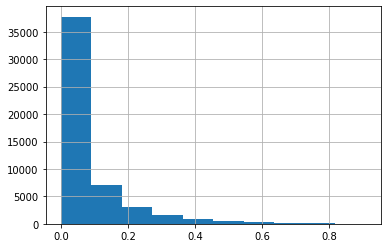

In [20]:
dataset.loc[(dataset.y == 0), 'loio_pred'].hist()

<AxesSubplot:>

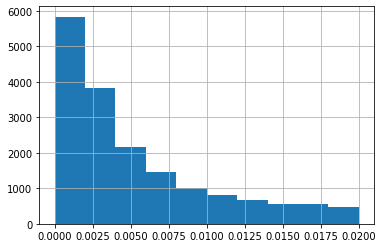

In [21]:
dataset.loc[(dataset.y == 0) & (dataset.loio_pred < 0.02), 'loio_pred'].hist()

In [22]:
good_samples = (dataset.y == 1) | ((dataset.loio_pred > 0.015) & (dataset.y == 0))

In [23]:
len(dataset.loc[(dataset.y == 0) & good_samples, 'id'].unique()) == len(dataset['id'].unique())

True

In [24]:
best_params = {
    'learning_rate': 0.00522903409129151,
    'l2_leaf_reg': 0.003570650864945256,
    'min_data_in_leaf': 406,
    'max_depth': 7,
    'grow_policy': 'SymmetricTree',
    'objective': 'Logloss',
    'iterations': 5000,
    'use_best_model': True,
    'per_float_feature_quantization': golden_feature,
    'thread_count': -1,
    'random_seed': 13,
}

In [25]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import joblib

kf = KFold(n_splits=5, shuffle=True, random_state=42)
inner_kf = KFold(n_splits=5, shuffle=True, random_state=239)

dataset_ids = dataset['id'].unique()

for i, (tr_id, va_id) in enumerate(kf.split(dataset_ids)):
    valid = dataset.loc[dataset['id'].isin([dataset_ids[x] for x in va_id])].reset_index(drop=True)
    x_valid, y_valid = valid.drop(columns=['id', 'y', 'time']).values, valid['y'].values

    train_ids = [dataset_ids[x] for x in tr_id]
    for j, (itr_id, iva_id) in enumerate(inner_kf.split(train_ids)):
        train = dataset.loc[dataset['id'].isin([train_ids[x] for x in itr_id])].reset_index(drop=True)
        x_train, y_train = train.drop(columns=['id', 'y', 'time']).values, train['y'].values
        pred_df = dataset.loc[dataset['id'].isin([train_ids[x] for x in iva_id])].reset_index(drop=True)
        
        #print(x_valid.shape[0], train.shape[0], pred_df.shape[0], dataset.shape[0])
        assert x_valid.shape[0] + train.shape[0] + pred_df.shape[0] == dataset.shape[0]
        assert len(set(valid['id'].unique()) & set(train['id'].unique())) == 0
        assert len(set(valid['id'].unique()) & set(pred_df['id'].unique())) == 0

In [27]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import joblib

kf = KFold(n_splits=5, shuffle=True, random_state=42)
inner_kf = KFold(n_splits=5, shuffle=True, random_state=239)

scores = []
thresholds = []
feature_importances_global = []

for i in range(5):
    dataset['pred_fold_'+str(i)] = np.nan

dataset_ids = dataset['id'].unique()
for i, (tr_id, va_id) in enumerate(kf.split(dataset['id'].unique())):
    valid = dataset.loc[dataset['id'].isin([dataset_ids[x] for x in va_id])].reset_index(drop=True)
    x_valid, y_valid = valid.drop(columns=['id', 'y', 'time']).values, valid['y'].values

    train_ids = [dataset_ids[x] for x in tr_id]
    for j, (itr_id, iva_id) in enumerate(inner_kf.split(tr_id)):
        train = dataset.loc[dataset['id'].isin([train_ids[x] for x in itr_id]) & good_samples].reset_index(drop=True)
        x_train, y_train = train.drop(columns=['id', 'y', 'time']).values, train['y'].values
    
        catboost_model = CatBoostClassifier(**best_params)
        catboost_model.fit(x_train, y_train, eval_set=(x_valid, y_valid), silent=True, plot=False, early_stopping_rounds=100)
        joblib.dump(catboost_model, 'cat_model_'+str(i)+'_'+str(j)+'.joblib')
        best_th, _ = threshold_search(y_train, catboost_model.predict_proba(x_train)[:, 1])
        predict = (catboost_model.predict_proba(x_valid)[:, 1] > best_th).astype(int)
        score = f1_score(y_valid, predict)
        print(i,j,best_th, score)
        scores.append(score)
        thresholds.append(best_th)
        
        pred_df = dataset.loc[dataset['id'].isin([train_ids[x] for x in iva_id])].reset_index(drop=True)
        x_pred = pred_df.drop(columns=['id', 'y', 'time']).values
        
        dataset.loc[dataset['id'].isin([train_ids[x] for x in iva_id]), 'pred_fold_'+str(i)] = catboost_model.predict_proba(x_pred)[:, 1]
    
        feature_importances_global.append(catboost_model.feature_importances_)

0 0 0.40063121802402485 0.8153098420413124
0 1 0.4343439857514024 0.8090028133791809
0 2 0.4249162492545372 0.8203753351206434
0 3 0.44483543062380165 0.7935323383084576
0 4 0.46893430472168035 0.0
1 0 0.4880285106233669 0.6696812118471627
1 1 0.28773002857289504 0.6541598694942904
1 2 0.38185055556806063 0.661403883080862
1 3 0.4868082915377155 0.6674162356644928
1 4 0.4133022810015664 0.0
2 0 0.4206618252582005 0.8380689655172414
2 1 0.4131017961995884 0.8317046688382194
2 2 0.3942457375270858 0.7970309700537496
2 3 0.36193876579351064 0.7857683573050718
2 4 0.4355698521890462 0.0
3 0 0.38749098790864955 0.8457490999723069
3 1 0.41289161076398706 0.8436819172113289
3 2 0.3716016911321578 0.8408229561451002
3 3 0.3627764629318184 0.826098826098826
3 4 0.4377658729960862 0.0
4 0 0.4380916622069316 0.8521555144141761
4 1 0.4183739785795107 0.8525189245627773
4 2 0.4157792881985789 0.8457112970711297
4 3 0.3777525025981592 0.8418107833163784
4 4 0.41779116541022826 0.0


In [33]:
dataset_ids = dataset['id'].unique()
for i, (tr_id, va_id) in enumerate(kf.split(dataset['id'].unique())):
    valid = dataset.loc[dataset['id'].isin([dataset_ids[x] for x in va_id])].reset_index(drop=True)
    x_valid, y_valid = valid.drop(columns=['id', 'y', 'time']).values, valid['y'].values

    train_ids = [dataset_ids[x] for x in tr_id]
    for j, (itr_id, iva_id) in enumerate(inner_kf.split(tr_id)):
        if j > 0:
            continue
        train = dataset.loc[dataset['id'].isin([train_ids[x] for x in itr_id]) & good_samples].reset_index(drop=True)
        x_train, y_train = train.drop(columns=['id', 'y', 'time']).values, train['y'].values
    
        catboost_model = CatBoostClassifier(**best_params)
        catboost_model.fit(x_train, y_train, eval_set=(x_valid, y_valid), silent=True, plot=True, early_stopping_rounds=100)
        joblib.dump(catboost_model, 'cat_model_'+str(i)+'_'+str(j)+'.joblib')
        best_th, _ = threshold_search(y_valid, catboost_model.predict_proba(x_valid)[:, 1])
        predict = (catboost_model.predict_proba(x_valid)[:, 1] > best_th).astype(int)
        score = f1_score(y_valid, predict)
        print(i,j,best_th, score)
        scores[i*5+j] = score
        thresholds[i*5+j] = best_th
        
        pred_df = dataset.loc[dataset['id'].isin([train_ids[x] for x in iva_id])].reset_index(drop=True)
        x_pred = pred_df.drop(columns=['id', 'y', 'time']).values
        
        dataset.loc[dataset['id'].isin([train_ids[x] for x in iva_id]), 'pred_fold_'+str(i)] = catboost_model.predict_proba(x_pred)[:, 1]
    
        feature_importances_global[i*5+j] = catboost_model.feature_importances_

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0 4 0.4708882944126441 0.3136882129277567


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1 4 0.4521244072937412 0.6657706093189963


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [31]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import joblib

kf = KFold(n_splits=5, shuffle=True, random_state=42)
inner_kf = KFold(n_splits=5, shuffle=True, random_state=239)

dataset_ids = dataset['id'].unique()

for i, (tr_id, va_id) in enumerate(kf.split(dataset_ids)):
    valid = dataset.loc[dataset['id'].isin([dataset_ids[x] for x in va_id])].reset_index(drop=True)
    x_valid, y_valid = valid.drop(columns=['id', 'y', 'time']).values, valid['y'].values

    train_ids = [dataset_ids[x] for x in tr_id]
    for j, (itr_id, iva_id) in enumerate(inner_kf.split(train_ids)):
        train = dataset.loc[dataset['id'].isin([train_ids[x] for x in itr_id])].reset_index(drop=True)
        x_train, y_train = train.drop(columns=['id', 'y', 'time']).values, train['y'].values
        pred_df = dataset.loc[dataset['id'].isin([train_ids[x] for x in iva_id])].reset_index(drop=True)
        if j == 4:
            print(train['id'].unique())
        print(x_valid.shape[0], train.shape[0], pred_df.shape[0], dataset.shape[0])
        assert x_valid.shape[0] + train.shape[0] + pred_df.shape[0] == dataset.shape[0]
        assert len(set(valid['id'].unique()) & set(train['id'].unique())) == 0
        assert len(set(valid['id'].unique()) & set(pred_df['id'].unique())) == 0

12110 35834 12543 60487
12110 36576 11801 60487
12110 38368 10009 60487
12110 40403 7974 60487
[  1   2   3   4   5   6   7  10  12  14  15  19  22  25  27  29  30  31
  33  34  35  36  39  40  41  43  45  46  47  49  52  53  55  57  58  60
  61  62  63  64  65  66  67  68  69  71  72  73  74  77  78  80  86  88
  89  91  92  93  97 101 102 103 104 107 108 109 111 112 116 117 118 120
 121 123 124 125 127 128 129 132 133 134 136 139 140 143 144 145 149 151
 152 153 155 156 158 159 162 163 164 167 172 177 178 179 180 182 185 187
 188 189 190 193 194 196 199 201 204 206 207 213 214 217 219 220 221 223
 226 229 230 232 236 238 239 240 241 244 246 250 253 258 259 261 262 263
 265 268 272]
12110 42327 6050 60487
16620 36742 7125 60487
16620 32942 10925 60487
16620 37745 6122 60487
16620 30593 13274 60487
[  1   2   3   4   5   7  10  12  13  15  17  21  22  23  24  25  27  29
  30  32  33  34  38  40  41  44  47  48  52  54  57  58  59  60  62  64
  67  68  69  70  71  72  73  74  76  80  82

In [58]:
dataset_ids = dataset['id'].unique()
for i, (tr_id, va_id) in enumerate(kf.split(dataset['id'].unique())):
    valid = dataset.loc[dataset['id'].isin([dataset_ids[x] for x in va_id])].reset_index(drop=True)
    x_valid, y_valid = valid.drop(columns=['id', 'y', 'time']).values, valid['y'].values

    train_ids = [dataset_ids[x] for x in tr_id]
    for j, (itr_id, iva_id) in enumerate(inner_kf.split(tr_id)):
        catboost_model = joblib.load('cat_model_'+str(i)+'_'+str(j)+'.joblib')
        pred_df = dataset.loc[dataset['id'].isin([train_ids[x] for x in iva_id])].reset_index(drop=True)
        x_pred = pred_df.drop(columns=['id', 'y', 'time']).values
        dataset.loc[dataset['id'].isin([train_ids[x] for x in iva_id]), 'pred_fold_'+str(i)] = catboost_model.predict_proba(x_pred)[:, 1]
        
        best_th, _ = threshold_search(y_valid, catboost_model.predict_proba(x_valid)[:, 1])
        predict = (catboost_model.predict_proba(x_valid)[:, 1] > best_th).astype(int)
        score = f1_score(y_valid, predict)
        print(i,j,best_th, score)

0 0 0.28512680978655575 0.8237657864523537
0 1 0.2761868252647217 0.8260238164391519
0 2 0.3773781347912303 0.8250363901018922
0 3 0.3723319333769019 0.8003607937462418
0 4 0.22714238249546911 0.7967337416156314
1 0 0.4792115128829283 0.6816976127320954
1 1 0.6283852856699746 0.6892365164604249
1 2 0.527178370145651 0.6847655373569665
1 3 0.568541968768211 0.6886075949367089
1 4 0.4072552650177699 0.6622251832111926
2 0 0.6665757873921871 0.8444184002343978
2 1 0.5862903260696692 0.8396816372939171
2 2 0.7505952317131847 0.8273444347063978
2 3 0.6770613373248411 0.828368794326241
2 4 0.2084391288993419 0.8081494057724958
3 0 0.39637307695114365 0.8424276169265034
3 1 0.43735857067673495 0.8390836323488821
3 2 0.5863018984131596 0.8409672830725462
3 3 0.5614640032983996 0.8291571753986333
3 4 0.18404282395003155 0.8217230594256468
4 0 0.65124058345594 0.853582554517134
4 1 0.6653560367026153 0.8605714285714285
4 2 0.5669152091713865 0.8573002754820935
4 3 0.6269208236693915 0.8612119519

In [52]:
cat_cols = ['pred_fold_'+str(i) for i in range(5)]
dataset['cat_predict'] = dataset[cat_cols].mean(axis=1)
np.save('cat_predict.npy', dataset['cat_predict'].values)
np.save('cat_predict_full.npy', dataset[cat_cols].values)

In [57]:
dataset[cat_cols + ['y']].loc[dataset.y == 1].head(20)

,pred_fold_0,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,y
353,0.008578,0.033408,NaN,0.009828,0.007310,1
354,0.007612,0.032213,NaN,0.007797,0.004818,1
355,0.005036,0.030811,NaN,0.007663,0.003329,1
356,0.018446,0.044954,NaN,0.012934,0.006668,1
357,0.630636,0.810652,NaN,0.856580,0.839914,1
358,0.970713,0.954512,NaN,0.948902,0.937148,1
359,0.999192,0.995408,NaN,0.995809,0.998604,1
360,0.997859,0.993198,NaN,0.985671,0.997947,1
361,0.961325,0.943816,NaN,0.948401,0.984834,1
362,0.995968,0.989614,NaN,0.988183,0.999016,1


In [53]:
total_score = f1_score(dataset['y'].values, (dataset['cat_predict'] > np.mean(thresholds)).astype(int))
print('mean threshold:', np.mean(thresholds))
print('total score:', total_score)

mean threshold: 0.411605545457488
total score: 0.7743197183885567


In [ ]:
for f, score in enumerate(scores):
    print(f'Fold {f}. F1 = {score:.4f}')

print(f'Mean = {np.mean(scores):.4f}')
print(f'Std = {np.std(scores):.4f}')

In [40]:
for f, score in enumerate(scores):
    print(f'Fold {f}. F1 = {score:.4f}')

print(f'Mean = {np.mean(scores):.4f}')
print(f'Std = {np.std(scores):.4f}')

Fold 0. F1 = 0.9035
Fold 1. F1 = 0.9029
Fold 2. F1 = 0.8977
Fold 3. F1 = 0.8425
Fold 4. F1 = 0.0481
Fold 5. F1 = 0.9628
Fold 6. F1 = 0.9445
Fold 7. F1 = 0.6128
Fold 8. F1 = 0.7372
Fold 9. F1 = 0.5665
Fold 10. F1 = 0.8974
Fold 11. F1 = 0.9164
Fold 12. F1 = 0.9238
Fold 13. F1 = 0.8453
Fold 14. F1 = 0.6070
Fold 15. F1 = 0.9207
Fold 16. F1 = 0.9099
Fold 17. F1 = 0.9293
Fold 18. F1 = 0.7802
Fold 19. F1 = 0.6098
Fold 20. F1 = 0.8830
Fold 21. F1 = 0.8883
Fold 22. F1 = 0.8995
Fold 23. F1 = 0.8366
Fold 24. F1 = 0.0474
Mean = 0.7725
Std = 0.2425
Fold 0. F1 = 0.9035
Fold 1. F1 = 0.9029
Fold 2. F1 = 0.8977
Fold 3. F1 = 0.8425
Fold 4. F1 = 0.0481
Fold 5. F1 = 0.9628
Fold 6. F1 = 0.9445
Fold 7. F1 = 0.6128
Fold 8. F1 = 0.7372
Fold 9. F1 = 0.5665
Fold 10. F1 = 0.8974
Fold 11. F1 = 0.9164
Fold 12. F1 = 0.9238
Fold 13. F1 = 0.8453
Fold 14. F1 = 0.6070
Fold 15. F1 = 0.9207
Fold 16. F1 = 0.9099
Fold 17. F1 = 0.9293
Fold 18. F1 = 0.7802
Fold 19. F1 = 0.6098
Fold 20. F1 = 0.8830
Fold 21. F1 = 0.8883
Fold 2

In [43]:
for i in range(5):
    print(i, scores[i*5])

0 0.903467029231815
1 0.9628113271920845
2 0.8974069898534386
3 0.9207232267037552
4 0.8830449826989618
0 0.903467029231815
1 0.9628113271920845
2 0.8974069898534386
3 0.9207232267037552
4 0.8830449826989618
0 0.903467029231815
1 0.9628113271920845
2 0.8974069898534386
3 0.9207232267037552
4 0.8830449826989618
0 0.903467029231815
1 0.9628113271920845
2 0.8974069898534386
3 0.9207232267037552
4 0.8830449826989618
